#### Import Libraries

In [8]:
import pandas as pd
import json
import os
import glob

from datetime import datetime

import collections
import emoji
import regex

import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'))
from wordcloud import WordCloud

from IPython.display import Image
pd.options.display.max_colwidth = 1000

import matplotlib.pyplot as plt
%matplotlib inline

#### Load the json files into a dataframe and join the dataframes together

In [9]:
path = '/Users/jodizhang/Documents/Python Projects/fb_messenger_history_raw_data/messages/inbox/RichardYang_UBTWFdX5og'
with open(f'{path}/message_1.json', encoding='ascii') as file:
    chat_history1 = json.load(file)
messages1 = pd.DataFrame(chat_history1['messages'])

path = '/Users/jodizhang/Documents/Python Projects/fb_messenger_history_raw_data/messages/inbox/RichardYang_UBTWFdX5og'
with open(f'{path}/message_2.json',encoding='ascii') as file:
    chat_history2 = json.load(file)
messages2 = pd.DataFrame(chat_history2['messages'])

path = '/Users/jodizhang/Documents/Python Projects/fb_messenger_history_raw_data/messages/inbox/RichardYang_UBTWFdX5og'
with open(f'{path}/message_3.json',encoding='ascii') as file:
    chat_history3 = json.load(file)
messages3 = pd.DataFrame(chat_history3['messages'])

path = '/Users/jodizhang/Documents/Python Projects/fb_messenger_history_raw_data/messages/inbox/RichardYang_UBTWFdX5og'
with open(f'{path}/message_4.json',encoding='ascii') as file:
    chat_history4 = json.load(file)
messages4 = pd.DataFrame(chat_history4['messages'])

messages = messages1.append([messages2,messages3,messages4], sort=True)

##### Clean up the data

In [10]:
messages['datetime']= messages['timestamp_ms'].apply(lambda x: datetime.fromtimestamp(x / 1000))
messages['month'] = messages['datetime'].apply(lambda x: x.month)
messages['year'] = messages['datetime'].apply(lambda x: x.year)
messages['date'] = messages['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
messages['weekday'] = messages['datetime'].apply(lambda x: x.strftime('%a'))
messages['yearmonth'] = messages['datetime'].apply(lambda x: x.strftime('%Y-%m'))
messages['content'] = messages['content'].astype(str).apply(lambda x: x.encode('raw_unicode_escape').decode('utf-8'))

In [11]:
messages['sticker'] = messages['sticker'].astype(str)
messages['gifs'] = messages['gifs'].astype(str)
messages['sticker']= messages['sticker'].apply(lambda x: x[9:-2] if x!='nan' else x)
messages['gifs']= messages['gifs'].apply(lambda x: x[10:-3] if x!='nan' else x)

In [13]:
messages['wordcount']= messages['content'].apply(lambda s: len(s.split(' ')) if s!='nan' else s)
messages['wordcount'].replace('nan', 0, inplace=True)
messages['wordcount'].astype(int)

0        2
1       11
2        5
3        5
4       11
        ..
6143     1
6144     4
6145     1
6146    13
6147     4
Name: wordcount, Length: 36148, dtype: int64

In [14]:
messages.sort_values(by=['datetime'], inplace=True)
messages.reset_index(drop=True, inplace=True)
messages.dtypes

audio_files              object
call_duration           float64
content                  object
files                    object
gifs                     object
missed                   object
photos                   object
reactions                object
sender_name              object
share                    object
sticker                  object
timestamp_ms              int64
type                     object
videos                   object
datetime         datetime64[ns]
month                     int64
year                      int64
date                     object
weekday                  object
yearmonth                object
wordcount                 int64
dtype: object

#### Create .csv files for the data I want to be displayed on my dashboard
I did not want to include the source .json files which were raw conversation data on github

In [19]:
df = messages[(messages['content']!='nan') & (messages['sender_name']=='Jodi Zhang')].groupby(['date'])['content'].count().to_frame(name='count').reset_index()
df1 = messages[(messages['content']!='nan') & (messages['sender_name']=='Richard Yang')].groupby(['date'])['content'].count().to_frame(name='count').reset_index()

total_df = pd.merge(df,df1,how='outer',on='date')
total_df.rename(columns={'count_x':'jodi_count','count_y':'richard_count'}, inplace=True)
total_df.fillna(0,inplace=True)
total_df.sort_values('date', inplace=True)
total_df.to_csv('/Users/jodizhang/Documents/Python Projects/fb_messenger_dashboard/data/messagestimeline.csv')


In [20]:
df2 = messages[(messages['sender_name']=='Jodi Zhang')&(messages['content'].str.contains('video chat ended'))&(((messages['year']==2019)&(messages['month'].isin([10,11,12])))|(messages['year']==2020))].groupby(['date'])['content'].count().to_frame(name='count').reset_index()
df3 = messages[(messages['sender_name']=='Richard Yang')&(messages['content'].str.contains('video chat ended'))&(((messages['year']==2019)&(messages['month'].isin([10,11,12])))|(messages['year']==2020))].groupby(['date'])['content'].count().to_frame(name='count').reset_index()

total_df = pd.merge(df2,df3,how='outer',on='date')
total_df.rename(columns={'count_x':'jodi_count','count_y':'richard_count'}, inplace=True)
total_df.fillna(0,inplace=True)
total_df.sort_values('date', inplace=True)
total_df.to_csv('/Users/jodizhang/Documents/Python Projects/fb_messenger_dashboard/data/videochattimeline.csv')

In [21]:
df4 = messages[(messages['content']!=0) & (messages['sender_name']=='Jodi Zhang')].groupby(['yearmonth']).agg({'wordcount':'sum'}).reset_index()
df5 = messages[(messages['content']!=0) & (messages['sender_name']=='Richard Yang')].groupby(['yearmonth']).agg({'wordcount':'sum'}).reset_index()

total_df = pd.merge(df4,df5,how='outer',on='yearmonth')
total_df.rename(columns={'wordcount_x':'jodi_count','wordcount_y':'richard_count'}, inplace=True)
total_df.fillna(0,inplace=True)
total_df.sort_values('yearmonth', inplace=True)
total_df.to_csv('/Users/jodizhang/Documents/Python Projects/fb_messenger_dashboard/data/monthlywordcount.csv')


In [139]:
df6 = messages[messages['sender_name']=='Jodi Zhang'].groupby(['weekday']).agg({'content':'count'}).reset_index()
df6['weekday'] = pd.Categorical(df6['weekday'],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
df7 = messages[messages['sender_name']=='Richard Yang'].groupby(['weekday']).agg({'content':'count'}).reset_index()
df7['weekday'] = pd.Categorical(df7['weekday'],['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

total_df = pd.merge(df6,df7,how='outer',on='weekday')
total_df.rename(columns={'content_x':'jodi_count','content_y':'richard_count'}, inplace=True)
total_df.sort_values('weekday', inplace=True)
total_df.to_csv('/Users/jodizhang/Documents/Python Projects/fb_messenger_dashboard/data/activitybyweekday.csv')

In [23]:
# totals breakdown by sender
content = messages[messages['content']!='nan'].groupby('sender_name').agg({'content':'count'}).reset_index()
gifs = messages[messages['gifs']!='nan'].groupby('sender_name').agg({'gifs':'count'}).reset_index()
sticker = messages[messages['sticker']!='nan'].groupby('sender_name').agg({'sticker':'count'}).reset_index()
media = messages.groupby(['sender_name']).agg({'files':'count','photos':'count','reactions':'count','share':'count','videos':'count'}).reset_index()

# merge into one table
media = pd.merge(media, content, how='inner', left_on='sender_name', right_on='sender_name')
media = pd.merge(media, gifs, how='inner', left_on='sender_name', right_on='sender_name')
media = pd.merge(media, sticker, how='inner', left_on='sender_name', right_on='sender_name')

media.to_csv('/Users/jodizhang/Documents/Python Projects/fb_messenger_dashboard/data/mediatotals.csv')

#### Create word cloud image

In [69]:
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(set(['lol','ok','oh','im','ya','yeah','i‚Äôm','omg',"i'm",'ill','it‚Äôs','also','i‚Äôll',"i'll",'uh','cause','thats','that‚Äôs','theres','yes',
                                   'dont','hows','lets','how‚Äôs',"what's",'what‚Äôs',"we're",'btw',"you're",'imma','hi','thanks','okk','lmao','okay','bc',"don't",'okkk',
                                   "there's",'lmaooo',"she's",'there‚Äôs','there‚Äôs']))

In [70]:
richard_words = messages[(messages['content']!='nan') & (messages['sender_name']=='Richard Yang')]['content'].tolist()
richard_words = [i.split(' ',1)[0] for i in richard_words]
richard_words = [x.lower() for x in richard_words]
richard_words = [x.replace("''",'') for x in richard_words]
richard_words = [x.replace("‚Äô'",'') for x in richard_words]
richard_words = [x.strip() for x in richard_words]

jodi_words = messages[(messages['content']!='nan') & (messages['sender_name']=='Jodi Zhang')]['content'].tolist()
jodi_words = [i.split(' ',1)[0] for i in jodi_words]
jodi_words = [x.lower() for x in jodi_words]
jodi_words = [x.replace("''",'') for x in jodi_words]
jodi_words = [x.replace("‚Äô'",'') for x in jodi_words]
jodi_words = [x.strip() for x in jodi_words]

In [71]:
richard_wordscleaned=[]

for word in richard_words:
    if word not in stop_words:
        richard_wordscleaned.append(word)
        
richards_wordcount = collections.Counter(richard_wordscleaned)

jodi_wordscleaned=[]

for word in jodi_words:
    if word not in stop_words:
        jodi_wordscleaned.append(word)
        
jodi_wordcount = collections.Counter(jodi_wordscleaned)

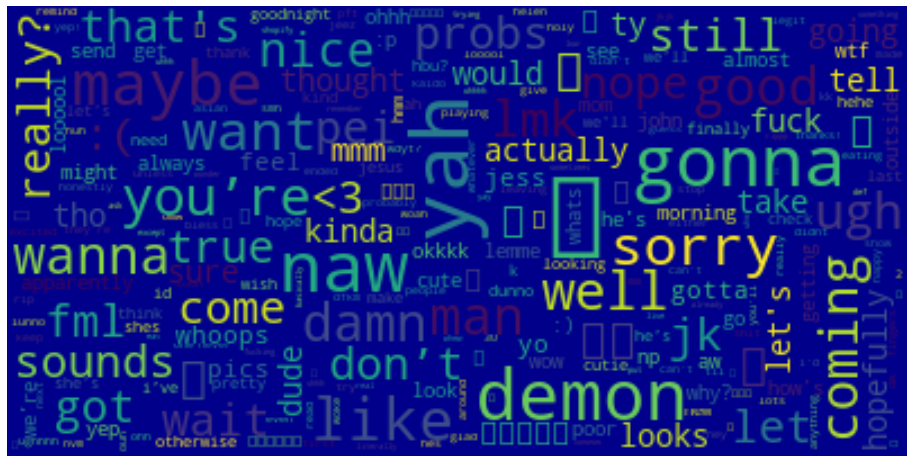

In [75]:
wc = WordCloud(max_font_size=50, max_words=250, background_color="darkblue").generate_from_frequencies(richards_wordcount)
wc.to_file("/Users/jodizhang/Documents/Python Projects/fb_messenger_history/assets/richardwordcloud.png")
fig = plt.figure()
fig.set_size_inches(20, 8.27)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

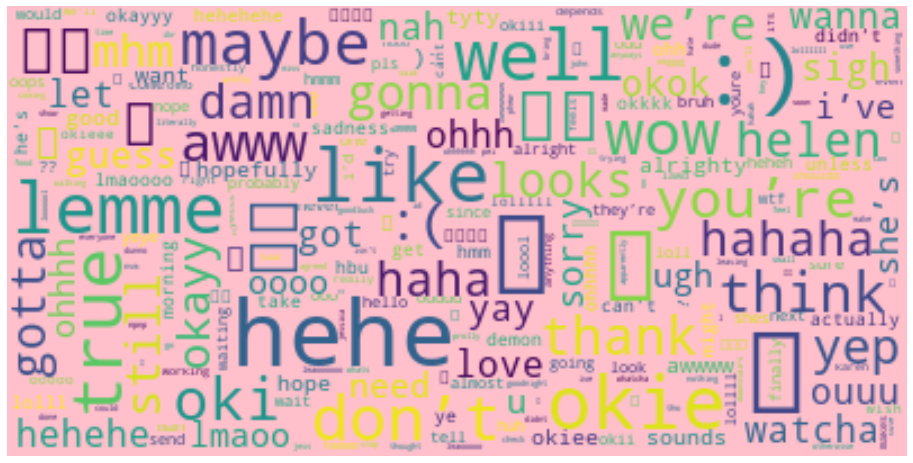

In [76]:
wc = WordCloud(max_font_size=50, max_words=250, background_color="pink").generate_from_frequencies(jodi_wordcount)
wc.to_file("/Users/jodizhang/Documents/Python Projects/fb_messenger_history/assets/jodiwordcloud.png")
fig = plt.figure()
fig.set_size_inches(20, 8.27)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Looking at the top Emojis used

In [78]:
jodi_wordsstr = ' '.join([str(elem) for elem in jodi_words]) 
richard_wordsstr = ' '.join([str(elem) for elem in richard_words]) 

In [79]:
def split_count(text):

    emoji_list = []
    demojize_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
            for em in word:
                demojize_list.append(emoji.demojize(em))
                
    return demojize_list

In [80]:
jodi_emojis = split_count(jodi_wordsstr)
jodi_emojis = list(filter(None, jodi_emojis))
jodi_emojis = [w.replace('\u200d', ':person_facepalming_light_skin_tone:') for w in jodi_emojis]
jodi_emojis = [w.replace(':light_skin_tone:', ':person_facepalming_light_skin_tone:') for w in jodi_emojis]
jodi_emojisfinal = []

for item in jodi_emojis:
    jodi_emojisfinal.append(emoji.emojize(item))
jodis_emojicount = collections.Counter(jodi_emojisfinal)

richard_emojis = split_count(richard_wordsstr)
richard_emojis = list(filter(None, richard_emojis))
richard_emojis = [w.replace('\u200d', ':person_facepalming_light_skin_tone:') for w in richard_emojis]
richard_emojis = [w.replace(':light_skin_tone:', ':person_facepalming_light_skin_tone:') for w in richard_emojis]
richards_emojisfinal = []

for item in richard_emojis:
    richards_emojisfinal.append(emoji.emojize(item))
richards_emojicount = collections.Counter(richards_emojisfinal)

In [81]:
print("Richard's top 10 emojis: ",richards_emojicount.most_common(10))
print("Jodi's top 10 emojis: ",jodis_emojicount.most_common(10))

Richard's top 10 emojis:  [('üê∑', 273), ('‚ù§', 85), ('ü§¶üèª', 78), ('ü•∞', 78), ('üòÇ', 59), ('üëÄ', 57), ('üòû', 47), ('üòò', 39), ('üñ§', 38), ('‚ôÇ', 29)]
Jodi's top 10 emojis:  [('üòÇ', 395), ('üòû', 245), ('üê∑', 231), ('‚ò∫', 167), ('‚ù§', 161), ('üòò', 126), ('üò¢', 68), ('üò≠', 57), ('ü•∫', 53), ('üòä', 39)]
